# Notebook dedicated to Implement event selection criteria using observables to obtain antinu like events. 

This notebook makes use of the nhits and reconstructed position to reject hotspot events and nhits to reject high energy suspected atmospheric events during 20s

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

import glob
import re
import os
import itertools
import pickle

In [2]:
def extract_file_number(filepath):
    """
    Extrae el número entre 'output_' y '_<var>.npy' desde el nombre del archivo.
    Ejemplo: output_104_clockCount50.npy → 104
    """
    filename = os.path.basename(filepath)
    match = re.search(r'output_(\d+)_\w+\.npy', filename)
    return int(match.group(1)) if match else -1  # -1 para poner errores al final


In [3]:
def posr_cal(x, y, z):
    dr = np.sqrt(x**2 + y**2 + z**2)
    return dr

In [4]:
def split_list(lista, n):
    """
    Divide una lista en `n` sublistas de tamaño lo más equilibrado posible.
    """
    k, m = divmod(len(lista), n)
    return [lista[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

# Load, Extract and Save Data

In [5]:
# Read directories paths and split Data to be loaded ------------------------------------------------------------------------------
main_dir_files = 'E:/Data/antinu/antinu_realdata/gold/numpy_files/analysisR/'
#name of variables to be used for the antinu analysis
var_read_name_list = ['energy', 'posx', 'posy', 'posz', 'clockCount50', 'nhits', 'runID']

#Code settings --------------------------------------------
#Data-split number:
n_split = 10

#general runID, energy and FV cuts:
runID_cut_on = True
runID_cut_inf = 300700  # events with runID < run_ID_cut_inf will be cut
en_cut_inf = 1.2
en_cut_sup = 8.0
posr_cut_sup = 5500

#Vetoing HS and atmospheric :
vetoing_on = True
nhits_hs_number = 1500  #nhits above this value is an hotspot suspected
nhits_atm_number = 3000 #nhits above this value is an atmospheric suspected
dt_hs_remove = 1e6  # Remove 1s of data after a hs
dt_atm_remove = 20*1e6  # Remove 20s of data after an atmospheric

# Antinu-finder algorithm:
#alpha = 9
#tau = 215
dt_sup_lim = 1000
dt_inf_lim = 0.5 # (0.5) -> To avoid retriggers

dr_sup_lim = 1000
dr_inf_lim = 0

energy_delay_sup_cut = 2.3
energy_delay_inf_cut = 1.9

#Dictionary Out Settings:
save_dict = True
dict_save_dir = 'antinu_dict/vetoing plus runID cut/'
dict_fname = f'antinuR_dict_delta_t_{dt_inf_lim}_{dt_sup_lim}(mcs)_dr_{dr_inf_lim}_{dr_sup_lim}(mm)_en_{en_cut_inf}_{en_cut_sup}(MeV)_R_{posr_cut_sup}(mm)_en_delay_{energy_delay_inf_cut}_{energy_delay_sup_cut}(MeV)'

#------------------------------------------------------------

#Information to save: Dictionary with the observables of interest for antinu candidates
antinu_dict = {'posx_prompt': [],
               'posy_prompt': [],
               'posz_prompt': [],
               'posx_delay': [],
               'posy_delay': [],
               'posz_delay': [],
               'energy_prompt': [],
			   'energy_delay': [],
			   'delta_t': [],
			   'delta_r': [],
               'hs_counter': [],
               'atm_counter': [],
               'runID': []
              }

energy_cut = np.array([])
posr_cut = np.array([])
hotspot_counter = 0
atm_counter = 0

#create the full directory list for each of the var_read_name_list by just adding '_summary' to the end of the names
for var_i in var_read_name_list:
    locals()['flist_' + var_i] = glob.glob(os.path.join(main_dir_files, var_i + '_summary', '*.npy'))
    locals()['flist_' + var_i].sort(key=extract_file_number)  # ordena por número en 'output_*_<var>.npy'

    #Create the splitten list of observables
    locals()['flist_split_' + var_i] = split_list(locals()['flist_' + var_i], n_split)

#Iteration over files -------------------------------------------------------------------------------------------------------------------
for i_dx in range(n_split):
    
    print(f'reading spliten files in iteration {i_dx}')
    #create a temporal dictionary with empty lists to be filled with the observable values:
    temp_obs_dict = {var_i: [] for var_i in var_read_name_list}
    
    #Extract sublist with the directory of observables
    for var_i in var_read_name_list:
        print(f'reading directories of observable {var_i}')
        dir_obs_i = locals()['flist_split_' + var_i][i_dx]  #extract the directories of the observabel var_i

        #Iterate over the files of the observable var_i and save info in temporal dictionary
        for file_i in dir_obs_i:
            arr = np.load(file_i, mmap_mode='r')
            temp_obs_dict[var_i].append(arr)

    #Now take the keys of the temp_obs_dict and transform data to numpy arrays and clean memory
    for var_i in var_read_name_list:
        print(f'flattening numpy array {var_i}')
        locals()[var_i] = np.concatenate(temp_obs_dict[var_i])  #Try to flatten the list of numpy arrays within the dictionary
        
        if var_i == 'posx' or var_i == 'posy' or var_i == 'posz':
            print(f'transforming data type {var_i}')
            locals()[var_i] = locals()[var_i].astype(np.float32)
            
        temp_obs_dict[var_i] = None

    # ====================== Run Selection ======================
    if runID_cut_on:
        
        print('performing runID selection')
        run_selection_condition = (runID > runID_cut_inf) #Run delection condition
        
        for var_i in var_read_name_list:
            locals()[var_i] = np.extract(run_selection_condition, locals()[var_i])

    # ====================== Vetoing events part ======================
    if vetoing_on:
        print('Performin Vetoing of Hotspots and Atmospherics')

        #hs_exist = False # By default is false. If there are hs events, then turn to True and the code will not enter to atm event remove code, even if nhits_atm_condition is satisfied

        # Define the Conditions ---------------------------------
        #nhits condition
        nhits_hs_condition = (nhits > nhits_hs_number)
        nhits_atm_condition = (nhits > nhits_atm_number)
        
        #position condition for hs events
        pos_condition_1 = (posx > 500) & (posx < 900) & (posy > -900) & (posy < -500) & (posz > 5300)
        pos_condition_2 = (posx > 0) & (posx < 500) & (posy > -1200) & (posy < -800) & (posz > 5300)
        pos_condition = (pos_condition_1) | (pos_condition_2)
        
        hs_condition = nhits_hs_condition & pos_condition    # Full hs Condition

        hs_index_to_remove = []  # List with the index to be removed from the data due to an suspected hs event
        atm_index_to_remove = [] # List with the index to be removed from the data due to an suspected atm event
        
        hs_ev_index = np.where(hs_condition)[0]  #Extract the index list which verifies the hs condition from the main observable arrays
        atm_ev_index = np.where(nhits_atm_condition)[0] #Extract the index list which verifies the atm nhits condition from the main observable arrays

        
        #Evaluates if there are repeated index of atm_ev_index in hs_ev_index. If is the case, remove theses elements from atm_ev_index
        #Conditions to correctly extract the np.in1d array
        #print('hs_index shape',hs_ev_index.shape)
        #print('atm_index shape', atm_ev_index.shape)
        if len(hs_ev_index) >= len(atm_ev_index):
            same_index_condition = np.in1d(atm_ev_index, hs_ev_index)
            index_to_del = np.where(same_index_condition)[0]
            atm_ev_index = np.delete(atm_ev_index, index_to_del)

        if len(atm_ev_index) > len(hs_ev_index):
            same_index_condition = np.in1d(hs_ev_index, atm_ev_index)
            index_to_del = np.where(same_index_condition)[0]
            atm_ev_index = np.delete(atm_ev_index, index_to_del)
            
        print(f' {len(hs_ev_index)} Hotspot like events were found in the loop of files')
        print(f'{len(atm_ev_index)} Atmospheric like events were found in the loop of files')
        
        # Hotspot Analysis Part -----------------------------
        # Enter in loop of hs events finder only if at least one hs event is found.
        if len(hs_ev_index) > 0:
            #hs_exist = True  #Turn True so atmospheric remove is not going to run
            print('In Hotspot Events Cut')
            hotspot_counter += len(hs_ev_index)
            
            #Now iterate over the hs_ev_index and evaluate the observables of interest (ClockCount50) and cut along 1s of Data
            for id_x in hs_ev_index:    
                #print(f'hs nhits = {nhits[id_x]}')
                hs_idx = id_x             # hs index of reference
                hs_next_idx = hs_idx + 1  # hs next event index

                #Save the index of the hs event
                hs_index_to_remove.append(hs_idx)
                
                time_hs = clockCount50[hs_idx]  #time of the hs event
    
                # Evaluate the time difference between the hs and the next event
                try:
                    time_next_hs =  clockCount50[hs_next_idx]
                    dt = time_next_hs - time_hs
                    
                except IndexError:
                    continue
    
                while (dt > 0) and (dt < dt_hs_remove):
                    #Save the next event index if while condition is satisfied
                    hs_index_to_remove.append(hs_next_idx)
    
                    #Update the hs_next_idx
                    hs_next_idx += 1
    
                    #Recompute the dt difference until dt_hs_remove is achieve or dt < 0
                    try:
                        time_next_hs =  clockCount50[hs_next_idx]
                        dt = time_next_hs - time_hs
                        
                    except IndexError:
                        break
                        
        # Atmospheric Analysis Part -----------------------------
        if len(atm_ev_index) > 0:
            #hs_exist = True  #Turn True so atmospheric remove is not going to run
            print('In Atmospheric Events Cut')
            atm_counter += len(atm_ev_index)
            
            #Now iterate over the atm_ev_index and evaluate the observables of interest (ClockCount50) and cut along 20s of Data
            for id_x in atm_ev_index:
                #print(f'atm nhits = {nhits[id_x]}')
                atm_idx = id_x             # atm index of reference
                atm_next_idx = atm_idx + 1  # atm ollowing event index

                #Save the index of the atm event
                atm_index_to_remove.append(atm_idx)
                
                time_atm = clockCount50[atm_idx]  #time of the atm event
    
                # Evaluate the time difference between the atm and the next event
                try:
                    time_next_atm =  clockCount50[atm_next_idx]
                    dt = time_next_atm - time_atm
                    
                except IndexError:
                    continue
    
                while (dt > 0) and (dt < dt_atm_remove):
                    #Save the next event index if while condition is satisfied
                    atm_index_to_remove.append(atm_next_idx)
    
                    #Update the hs_next_idx
                    atm_next_idx += 1
    
                    #Recompute the dt difference until dt_hs_remove is achieve or dt < 0
                    try:
                        time_next_atm =  clockCount50[atm_next_idx]
                        dt = time_next_atm - time_atm
                        
                    except IndexError:
                        break

        #Concatenate the index list of hs and atm
        full_index_to_remove = hs_index_to_remove + atm_index_to_remove
        
        #Remove the element-index of observables using the results of hs events, atm events and followers.
        runID = np.delete(runID, full_index_to_remove)
        energy = np.delete(energy, full_index_to_remove)   
        posx = np.delete(posx, full_index_to_remove)
        posy = np.delete(posy, full_index_to_remove)
        posz = np.delete(posz, full_index_to_remove)  
        clockCount50 = np.delete(clockCount50, full_index_to_remove)

    # =============== Selection of events based on Energy and FV cuts ===============

    #Compute radial position of events
    print('computing posr ...')
    posr = posr_cal(posx, posy, posz)

    print('performing energy and FV cuts')
    general_condition = (energy >= en_cut_inf) & (energy <= en_cut_sup) & (posr <= posr_cut_sup) #& (runID > 300700)

    energy = energy[general_condition]
    energy_cut = np.append(energy_cut, energy)
    
    posr = posr[general_condition]
    posr_cut = np.append(posr_cut, posr)
    
    posx = posx[general_condition]
    posy = posy[general_condition]
    posz = posz[general_condition]
    
    clockCount50 = clockCount50[general_condition]

    # Antinu-finder algorithm ------------------------------------------------------------------------
    print('Getting in antinu finder')
    #Data to save
    posx_prompt = []
    posy_prompt = []
    posz_prompt = []
    
    posx_delay = []
    posy_delay = []
    posz_delay = []
    
    delta_t = []
    delta_r = []
    
    energy_prompt = []
    energy_delay = []
    
    N_ev = energy.shape[0]
    
    for ev_i in range(N_ev):
    
        delay_index = ev_i + 1
        #print('In event', ev_i)
    
        #Suspected promt event observables
        t1 = clockCount50[ev_i]
        posx1 = posx[ev_i]
        posy1 = posy[ev_i]
        posz1 = posz[ev_i]
        energy_1 = energy[ev_i]
        runID_1 = runID[ev_i]
        
        try:
            #Suspected delayed
            t2 = clockCount50[delay_index]
            posx2 = posx[delay_index]
            posy2 = posy[delay_index]
            posz2 = posz[delay_index]
            energy_2 = energy[delay_index]
            runID_2 = runID[delay_index]
            
            #Evaluate the dr and dt between events
            dx = posx2 - posx1
            dy = posy2 - posy1
            dz = posz2 - posz1
            dr = np.sqrt(dx**2 + dy**2 + dz**2)
            dt = t2 - t1
            
        except IndexError:
            continue
    
        #print('intial prompt_i: ', ev_i)
        #print('intial delay_i: ', delay_index)
           
        #Start looking for a delay event within a windows alpha times tau
        while (dt > dt_inf_lim) and (dt <= dt_sup_lim):
            
            #print(f'prompt_i within dt interval. index = {ev_i}, t1 = {t1}')
            #print(f'delay_i within dt interval. index = {delay_index}, t2 = {t2}')
            #print(f'dt within interval = {dt}')
    
            # If the dr coincide with the expected values, then save the observables of interest and break the while
            #if (dr >= dr_exp - dr_unc) and (dr <= dr_exp + dr_unc) and (dt > 0) and (dt <= alpha*tau) and (energy_2 >= energy_delay_inf_cut) and (energy_2 <= energy_delay_sup_cut):
            if (dr >= dr_inf_lim) and (dr <= dr_sup_lim) and (dt > dt_inf_lim) and (dt <= dt_sup_lim) and (energy_2 >= energy_delay_inf_cut) and (energy_2 <= energy_delay_sup_cut):
                print('Pair Found')
                print(f'dr: {dr} and dt: {dt}')
                posx_prompt.append(posx1)
                posy_prompt.append(posy1)
                posz_prompt.append(posz1)
                
                posx_delay.append(posx2)
                posy_delay.append(posy2)
                posz_delay.append(posz2)
                
                delta_t.append(dt)
                delta_r.append(dr)
                
                energy_prompt.append(energy_1)
                energy_delay.append(energy_2)

                antinu_dict['runID'].append(int(runID_1))
                antinu_dict['runID'].append(int(runID_2))
    
                break
            # Evolve the delay index if the condition is not fulfilled
            delay_index += 1
    
            # Look for the next Suspected delayed
            try:
                t2 = clockCount50[delay_index]
                #print(f'actual prompt index = {ev_i}')
                #print(f'new delay candidate: index = {delay_index}, t2 ={t2}')
                posx2 = posx[delay_index]
                posy2 = posy[delay_index]
                posz2 = posz[delay_index]
                energy_2 = energy[delay_index]
                runID_2 = runID[delay_index]
        
                #Evaluate the dr and dt between events
                dx = posx2 - posx1
                dy = posy2 - posy1
                dz = posz2 - posz1
                dr = np.sqrt(dx**2 + dy**2 + dz**2)
                dt = t2 - t1
                #print(f'new dt = {dt}')
            except IndexError:
                break

    # Save the outputs of the antinu finder in the outer antinu dictionary
    print('saving observables in antinu dictionary')
    antinu_dict['posx_prompt'].append(posx_prompt)
    antinu_dict['posy_prompt'].append(posy_prompt)
    antinu_dict['posz_prompt'].append(posz_prompt)
    antinu_dict['posx_delay'].append(posx_delay)
    antinu_dict['posy_delay'].append(posy_delay)
    antinu_dict['posz_delay'].append(posz_delay)
    antinu_dict['energy_prompt'].append(energy_prompt)
    antinu_dict['energy_delay'].append(energy_delay)
    antinu_dict['delta_t'].append(delta_t)
    antinu_dict['delta_r'].append(delta_r)

#transform the dictionary entries to flatten numpy array
antinu_dict['posx_prompt'] = np.array(list(itertools.chain.from_iterable(antinu_dict['posx_prompt'])))
antinu_dict['posy_prompt'] = np.array(list(itertools.chain.from_iterable(antinu_dict['posy_prompt'])))
antinu_dict['posz_prompt'] = np.array(list(itertools.chain.from_iterable(antinu_dict['posz_prompt'])))
antinu_dict['posx_delay'] = np.array(list(itertools.chain.from_iterable(antinu_dict['posx_delay'])))
antinu_dict['posy_delay'] = np.array(list(itertools.chain.from_iterable(antinu_dict['posy_delay'])))
antinu_dict['posz_delay'] = np.array(list(itertools.chain.from_iterable(antinu_dict['posz_delay'])))
antinu_dict['energy_prompt'] = np.array(list(itertools.chain.from_iterable(antinu_dict['energy_prompt'])))
antinu_dict['energy_delay'] = np.array(list(itertools.chain.from_iterable(antinu_dict['energy_delay'])))
antinu_dict['delta_t'] = np.array(list(itertools.chain.from_iterable(antinu_dict['delta_t'])))
antinu_dict['delta_r'] = np.array(list(itertools.chain.from_iterable(antinu_dict['delta_r'])))
antinu_dict['hs_counter'].append(hotspot_counter)
antinu_dict['atm_counter'].append(atm_counter)
antinu_dict['runID'] = np.array(antinu_dict['runID'])

#save dictionary:
if save_dict:
    with open(dict_save_dir + dict_fname + '.pkl', 'wb') as f:
        pickle.dump(antinu_dict, f)

# Call the observables by their names and flat the lists
#energy_cut = np.concatenate(energy_cut)
#posr_cut = np.concatenate(posr_cut)
energy_prompt = antinu_dict['energy_prompt']
energy_delay = antinu_dict['energy_delay']
delta_t = antinu_dict['delta_t']
delta_r = antinu_dict['delta_r']

print('Finished')

reading spliten files in iteration 0
reading directories of observable energy
reading directories of observable posx
reading directories of observable posy
reading directories of observable posz
reading directories of observable clockCount50
reading directories of observable nhits
reading directories of observable runID
flattening numpy array energy
flattening numpy array posx
transforming data type posx
flattening numpy array posy
transforming data type posy
flattening numpy array posz
transforming data type posz
flattening numpy array clockCount50
flattening numpy array nhits
flattening numpy array runID
performing runID selection
Performin Vetoing of Hotspots and Atmospherics
 1286 Hotspot like events were found in the loop of files
5 Atmospheric like events were found in the loop of files
In Hotspot Events Cut
In Atmospheric Events Cut
computing posr ...
performing energy and FV cuts
Getting in antinu finder
Pair Found
dr: 562.9744250705818 and dt: 74.0
saving observables in antinu

# Load Previous saved Dictionaries

In [12]:
#define cuts to select file ----------------------------------------
en_cut_inf = 1.6
en_cut_sup = 8.0
posr_cut_sup = 5500

alpha = 9
tau = 215
dt_sup_lim = 1000
dt_inf_lim = 0.5

dr_sup_lim = 1000
dr_inf_lim = 0

energy_delay_sup_cut = 2.3
energy_delay_inf_cut = 1.9

dict_dir = 'antinu_dict/vetoing plus runID cut/'
dict_name = f'antinuR_dict_delta_t_{dt_inf_lim}_{dt_sup_lim}(mcs)_dr_{dr_inf_lim}_{dr_sup_lim}(mm)_en_{en_cut_inf}_{en_cut_sup}(MeV)_R_{posr_cut_sup}(mm)_en_delay_{energy_delay_inf_cut}_{energy_delay_sup_cut}(MeV)'

with open(dict_dir + dict_name + '.pkl', 'rb') as f:
    #locals()['antinu_dict_' + str(i_dx)] = pickle.load(f)
    antinu_dict = pickle.load(f)

energy_prompt = antinu_dict['energy_prompt']
energy_delay = antinu_dict['energy_delay']
delta_t = antinu_dict['delta_t']
delta_r = antinu_dict['delta_r']

In [14]:
antinu_dict

{'posx_prompt': array([-2810.0063 ,  2402.2737 ,    86.32442,   609.9128 ,  1336.2031 ,
        -1919.216  , -3720.0356 ,  2181.0112 , -2913.4836 ,  1953.8171 ,
        -1150.4418 ,  4282.266  ,   339.32797,  1234.6808 ,  -383.21628,
        -2917.2278 ,   780.1324 , -1149.2346 , -3829.893  ,  2753.1042 ,
         4364.065  ,  4322.1787 , -2749.1653 , -3088.1309 , -2037.2285 ,
         -180.7693 , -1382.2537 ,  -555.15485,   303.40137,  -433.40286,
         2960.261  , -3535.8381 ,  3853.148  ,   545.48   ], dtype=float32),
 'posy_prompt': array([-3097.245  , -2825.884  ,  1238.2738 , -1676.3712 , -1085.9158 ,
         -783.2192 ,  -720.98126,  3449.5688 ,  4188.08   , -2763.732  ,
        -3720.2412 , -1425.0074 ,  2481.5918 ,  2098.7998 ,  5428.491  ,
         -992.8345 , -1963.6438 ,  -278.33347, -3310.774  ,  2506.1577 ,
        -2031.1227 , -1841.8624 ,   883.1932 , -1715.6748 ,  2938.8848 ,
          642.637  ,  -611.3449 ,  4747.4434 ,  3178.4434 ,   802.55457,
        -4513.537

# Observe Raw Plots with Primal Cuts

In [17]:
energy_cut.shape

(75248,)

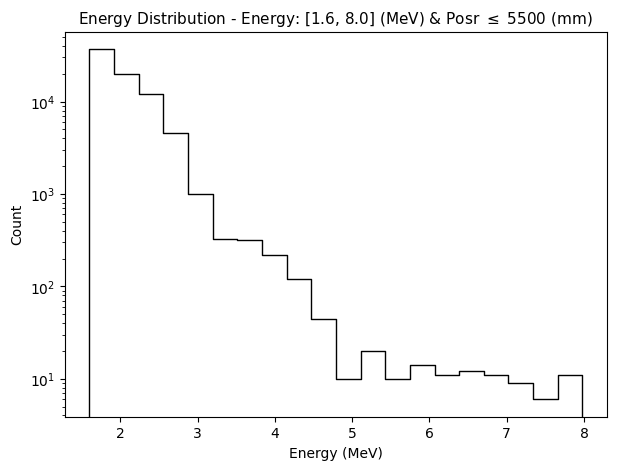

In [15]:
plt.figure(figsize=(7,5))

sn.histplot(energy_cut, bins = 20, color = 'black', element = 'step', alpha = 0)
plt.xlabel('Energy (MeV)')
plt.title(fr'Energy Distribution - Energy: [{en_cut_inf}, {en_cut_sup}] (MeV) & Posr $\leq$ {posr_cut_sup} (mm)', fontsize = 11)
plt.yscale('log')

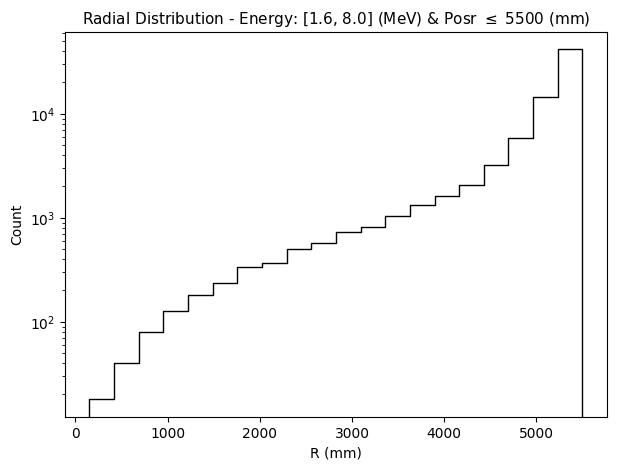

In [16]:
plt.figure(figsize=(7,5))
sn.histplot(posr_cut, bins = 20, color = 'black', element = 'step', alpha = 0)
plt.xlabel('R (mm)')
plt.title(rf'Radial Distribution - Energy: [{en_cut_inf}, {en_cut_sup}] (MeV) & Posr $\leq$ {posr_cut_sup} (mm)', fontsize = 11)
plt.yscale('log')

#Main selection Criteria for all events:
en_inf_cut = 0.5
en_sup_cut = 8

posr_cut = 5500

mask_cut = 0x2100000042C2

energy_cut_condition = (energy_analysis >= en_inf_cut) & (energy_analysis <= en_sup_cut)
posr_cut_condition = (posr_analysis <= posr_cut)
dcFlag_cut_condition = ((int(mask_cut) & dcFlagged_analysis) == int(mask_cut))

general_cut_condition = (energy_cut_condition) & (posr_cut_condition)# & dcFlag_cut_condition)

#Select observables within this cuts.
energy_cut = energy_analysis[general_cut_condition]
posx_cut = posx_analysis[general_cut_condition]
posy_cut = posy_analysis[general_cut_condition]
posz_cut = posz_analysis[general_cut_condition]
time_clock50_cut = clockCount50_analysis[general_cut_condition]

In [17]:
energy_delay.shape

(34,)

In [18]:
energy_prompt.shape

(34,)

# 5 - Plots

## 5.1 - Energy Spectrum

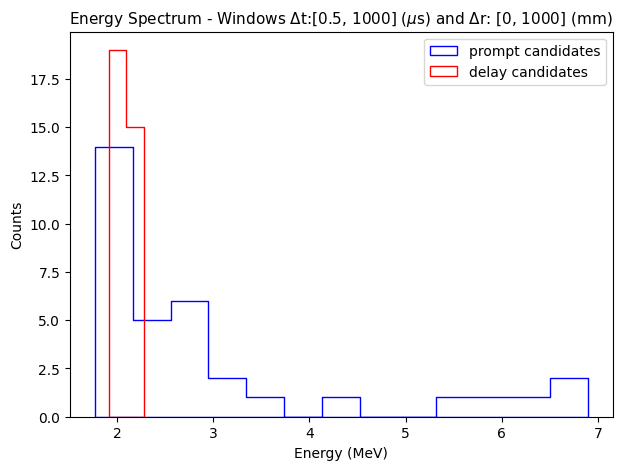

In [19]:
binwidth_prompt = 0.4
binwidth_delay = 0.2

bins = 3

plt.figure(figsize = (7,5))
sn.histplot(energy_prompt, binwidth = binwidth_prompt, color = 'b', element = 'step', alpha = 0, label = 'prompt candidates')
sn.histplot(energy_delay, binwidth = binwidth_delay, color = 'r', element = 'step', alpha = 0, label = 'delay candidates')
plt.legend(loc = 'best')

plt.xlabel('Energy (MeV)')
plt.ylabel(f'Counts')

#plt.yscale('log')

plt.title(rf'Energy Spectrum - Windows $\Delta$t:[{dt_inf_lim}, {dt_sup_lim}] ($\mu$s) and $\Delta$r: [{dr_inf_lim}, {dr_sup_lim}] (mm)', fontsize = 11)

plt.show()

## 5.2 - $\Delta$t

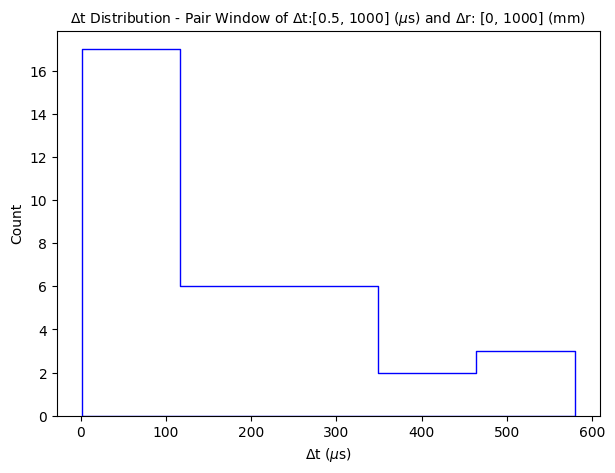

In [20]:
plt.figure(figsize = (7,5))

sn.histplot(delta_t, binwidth = 110, color = 'b', element = 'step', alpha = 0)

plt.xlabel(r'$\Delta$t ($\mu$s)')
plt.title(rf'$\Delta$t Distribution - Pair Window of $\Delta$t:[{dt_inf_lim}, {dt_sup_lim}] ($\mu$s) and $\Delta$r: [{dr_inf_lim}, {dr_sup_lim}] (mm)', fontsize = 10)

plt.show()

## 5.3 - $\Delta$r

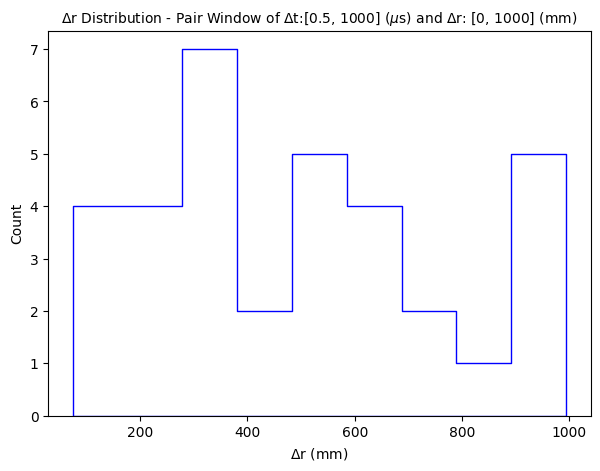

In [21]:
plt.figure(figsize = (7,5))

sn.histplot(delta_r, binwidth = 100, color = 'b', element = 'step', alpha = 0)

plt.xlabel(r'$\Delta$r (mm)')
plt.title(rf'$\Delta$r Distribution - Pair Window of $\Delta$t:[{dt_inf_lim}, {dt_sup_lim}] ($\mu$s) and $\Delta$r: [{dr_inf_lim}, {dr_sup_lim}] (mm)', fontsize = 10)

plt.show()

# Code line para limpiar información innecesariamente guardada en los diccionarios

In [34]:
#Primary energy and FV cuts:
en_cut_inf = 1.0
en_cut_sup = 8.0
posr_cut_sup = 5500

# Antinu-finder algorithm:
alpha = 9
tau = 215
dt_sup_lim = 1000
dt_inf_lim = 0.5 # (0.5) -> To avoid retriggers

dr_sup_lim = 600 
dr_inf_lim = 0

energy_delay_sup_cut = 3.5
energy_delay_inf_cut = 1.8


dict_read_dir = 'antinu_dict/'
dict_fname = f'antinuR_dict_delta_t_{dt_inf_lim}_{dt_sup_lim}(mcs)_dr_{dr_inf_lim}_{dr_sup_lim}(mm)_en_{en_cut_inf}_{en_cut_sup}(MeV)_R_{posr_cut_sup}(mm)_en_delay_{energy_delay_inf_cut}_{energy_delay_sup_cut}(MeV)'

flist_dir = glob.glob(dict_read_dir + '*.pkl')

for file_dir_i in flist_dir:

    #Extract the base name of the dictionary. Useful to resave the file with exactly the same name
    fname_base = os.path.basename(file_dir_i)

    #Open the dictionary
    with open(file_dir_i, 'rb') as f:
        antinu_dict = pickle.load(f)

    #delete unnecessary
    del antinu_dict['all_energy']
    del antinu_dict['all_posr']

    #save information
    with open(dict_save_dir + fname_base, 'wb') as f:
        pickle.dump(antinu_dict, f)

KeyError: 'all_energy'